# House Price Prediction Using Regression Models

## Objective
This notebook demonstrates a comprehensive approach to predicting house prices using property features such as area, bedrooms, bathrooms, and various amenities. We'll implement multiple regression models and compare their performance.

## Dataset Overview
The dataset contains various features that influence house prices including:
- **Numerical Features**: price, area, bedrooms, bathrooms, stories, parking
- **Categorical Features**: mainroad, guestroom, basement, hotwaterheating, airconditioning, prefarea, furnishingstatus

## Workflow
1. Data Loading and Exploration
2. Data Preprocessing
3. Feature Engineering
4. Model Training (Linear Regression & Gradient Boosting)
5. Model Evaluation and Comparison
6. Visualization and Insights

In [ ]:
# Import core libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import scikit-learn modules for preprocessing, modeling, and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Import statistical functions
from scipy import stats

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set visualization style and color palette
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

# Confirm successful import
print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Initial Exploration

In [ ]:
# Attempt to load the dataset from CSV file
try:
    df = pd.read_csv('Housing.csv')
    print("Dataset loaded successfully!")
    print(f"Shape: {df.shape}")  # Display number of rows and columns
except FileNotFoundError:
    # Handle case where file is missing
    print("Error: Housing.csv file not found. Please ensure the file is in the same directory.")
    df = None  # Set df to None to avoid downstream errors

Dataset loaded successfully!
Shape: (545, 13)


In [ ]:
# Display basic dataset information if loaded successfully
if df is not None:
    print("Dataset Info:")
    print("=" * 50)
    df.info()  # Show column types, non-null counts, and memory usage
    
    print("\nFirst 5 rows:")
    print("=" * 50)
    display(df.head())  # Preview the first five rows of the dataset
    
    print("\nDataset Statistics:")
    print("=" * 50)
    display(df.describe())  # Summary statistics for numerical columns

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB

First 5 rows:


price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished


Dataset Statistics:


price          area    bedrooms   bathrooms     stories  \
count  5.450000e+02    545.000000  545.000000  545.000000  545.000000   
mean   4.766729e+06   5150.541284    2.965138    1.286239    1.805505   
std    1.870440e+06   2170.141023    0.738064    0.502470    0.867492   
min    1.750000e+06   1650.000000    1.000000    1.000000    1.000000   
25%    3.430000e+06   3600.000000    2.000000    1.000000    1.000000   
50%    4.340000e+06   4600.000000    3.000000    1.000000    2.000000   
75%    5.740000e+06   6360.000000    3.000000    2.000000    2.000000   
max    1.330000e+07  16200.000000    6.000000    4.000000    4.000000   

          parking  
count  545.000000  
mean     0.693578  
std      0.861586  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      1.000000  
max      3.000000

In [ ]:
# Check for missing values and inspect data types if dataset is available
if df is not None:
    print("Missing Values:")
    print("=" * 30)
    missing_values = df.isnull().sum()  # Count missing values per column
    if missing_values.sum() == 0:
        print("No missing values found in the dataset!")
    else:
        print(missing_values[missing_values > 0])  # Display columns with missing values

    print("\nData Types:")
    print("=" * 30)
    print(df.dtypes)  # Show data types of each column

    print("\nUnique values in categorical columns:")
    print("=" * 40)
    categorical_columns = df.select_dtypes(include=['object']).columns  # Identify categorical columns
    for col in categorical_columns:
        print(f"{col}: {df[col].unique()}")  # Display unique values for each categorical column

Missing Values:
No missing values found in the dataset!

Data Types:
price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

Unique values in categorical columns:
mainroad: ['yes' 'no']
guestroom: ['no' 'yes']
basement: ['no' 'yes']
hotwaterheating: ['no' 'yes']
airconditioning: ['yes' 'no']
prefarea: ['yes' 'no']
furnishingstatus: ['furnished' 'semi-furnished' 'unfurnished']


## 2. Exploratory Data Analysis (EDA)

In [ ]:
# Visualize the distribution of the target variable (price)
if df is not None:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Create side-by-side plots

    # Plot raw price distribution
    axes[0].hist(df['price'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0].set_title('Distribution of House Prices', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Price')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True, alpha=0.3)

    # Plot log-transformed price distribution to reduce skewness
    axes[1].hist(np.log(df['price']), bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[1].set_title('Distribution of Log-Transformed House Prices', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Log(Price)')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Display summary statistics for price
    print(f"Price Statistics:")
    print(f"Mean: ${df['price'].mean():,.2f}")
    print(f"Median: ${df['price'].median():,.2f}")
    print(f"Standard Deviation: ${df['price'].std():,.2f}")
    print(f"Min: ${df['price'].min():,.2f}")
    print(f"Max: ${df['price'].max():,.2f}")

Price Statistics:
Mean: $4,766,729.25
Median: $4,340,000.00
Standard Deviation: $1,870,439.62
Min: $1,750,000.00
Max: $13,300,000.00


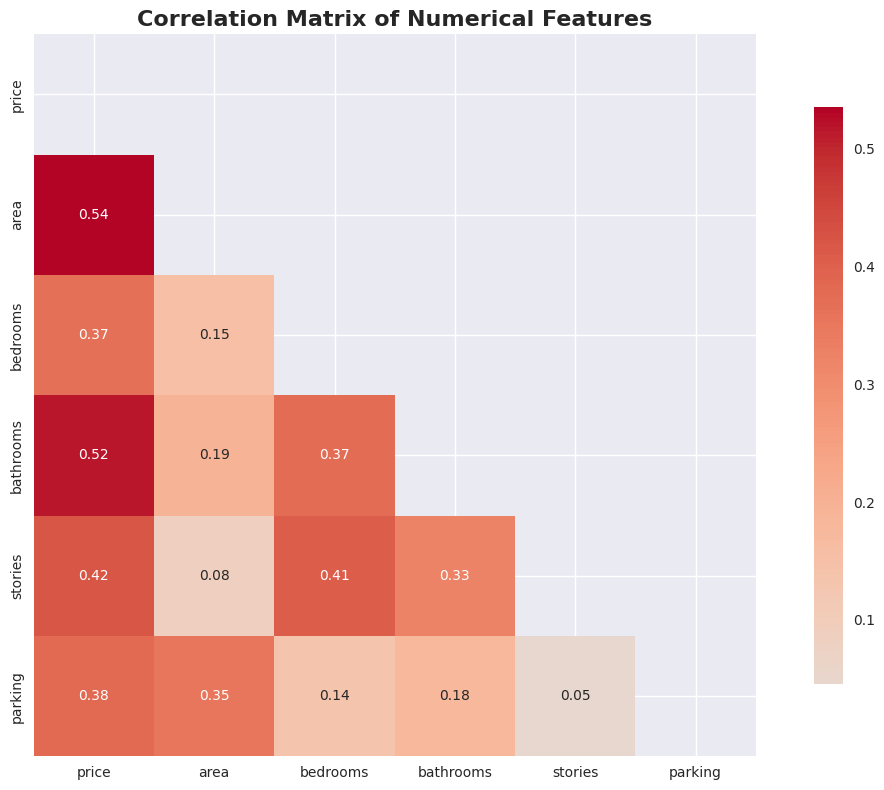

Features most correlated with price:
area         0.535997
bathrooms    0.517545
stories      0.420712
parking      0.384394
bedrooms     0.366494
Name: price, dtype: float64


In [ ]:
# Generate and visualize correlation matrix for numerical features
if df is not None:
    numerical_columns = df.select_dtypes(include=[np.number]).columns  # Select numerical columns
    correlation_matrix = df[numerical_columns].corr()  # Compute correlation matrix

    plt.figure(figsize=(12, 8))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle for cleaner display
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8})  # Plot heatmap
    plt.title('Correlation Matrix of Numerical Features', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Display features most correlated with price
    print("Features most correlated with price:")
    price_correlations = correlation_matrix['price'].abs().sort_values(ascending=False)
    print(price_correlations.drop('price'))  # Exclude self-correlation

In [ ]:
# Visualize relationships between key features and house price
if df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # Create a 2x2 grid of plots

    # Scatter plot: Price vs Area
    axes[0, 0].scatter(df['area'], df['price'], alpha=0.6, color='blue')
    axes[0, 0].set_title('Price vs Area', fontweight='bold')
    axes[0, 0].set_xlabel('Area (sq ft)')
    axes[0, 0].set_ylabel('Price')
    axes[0, 0].grid(True, alpha=0.3)

    # Box plot: Price distribution by number of bedrooms
    df.boxplot(column='price', by='bedrooms', ax=axes[0, 1])
    axes[0, 1].set_title('Price Distribution by Number of Bedrooms', fontweight='bold')
    axes[0, 1].set_xlabel('Number of Bedrooms')
    axes[0, 1].set_ylabel('Price')

    # Box plot: Price distribution by number of bathrooms
    df.boxplot(column='price', by='bathrooms', ax=axes[1, 0])
    axes[1, 0].set_title('Price Distribution by Number of Bathrooms', fontweight='bold')
    axes[1, 0].set_xlabel('Number of Bathrooms')
    axes[1, 0].set_ylabel('Price')

    # Box plot: Price distribution by number of stories
    df.boxplot(column='price', by='stories', ax=axes[1, 1])
    axes[1, 1].set_title('Price Distribution by Number of Stories', fontweight='bold')
    axes[1, 1].set_xlabel('Number of Stories')
    axes[1, 1].set_ylabel('Price')

    plt.suptitle('')  # Remove default subplot title
    plt.tight_layout()
    plt.show()

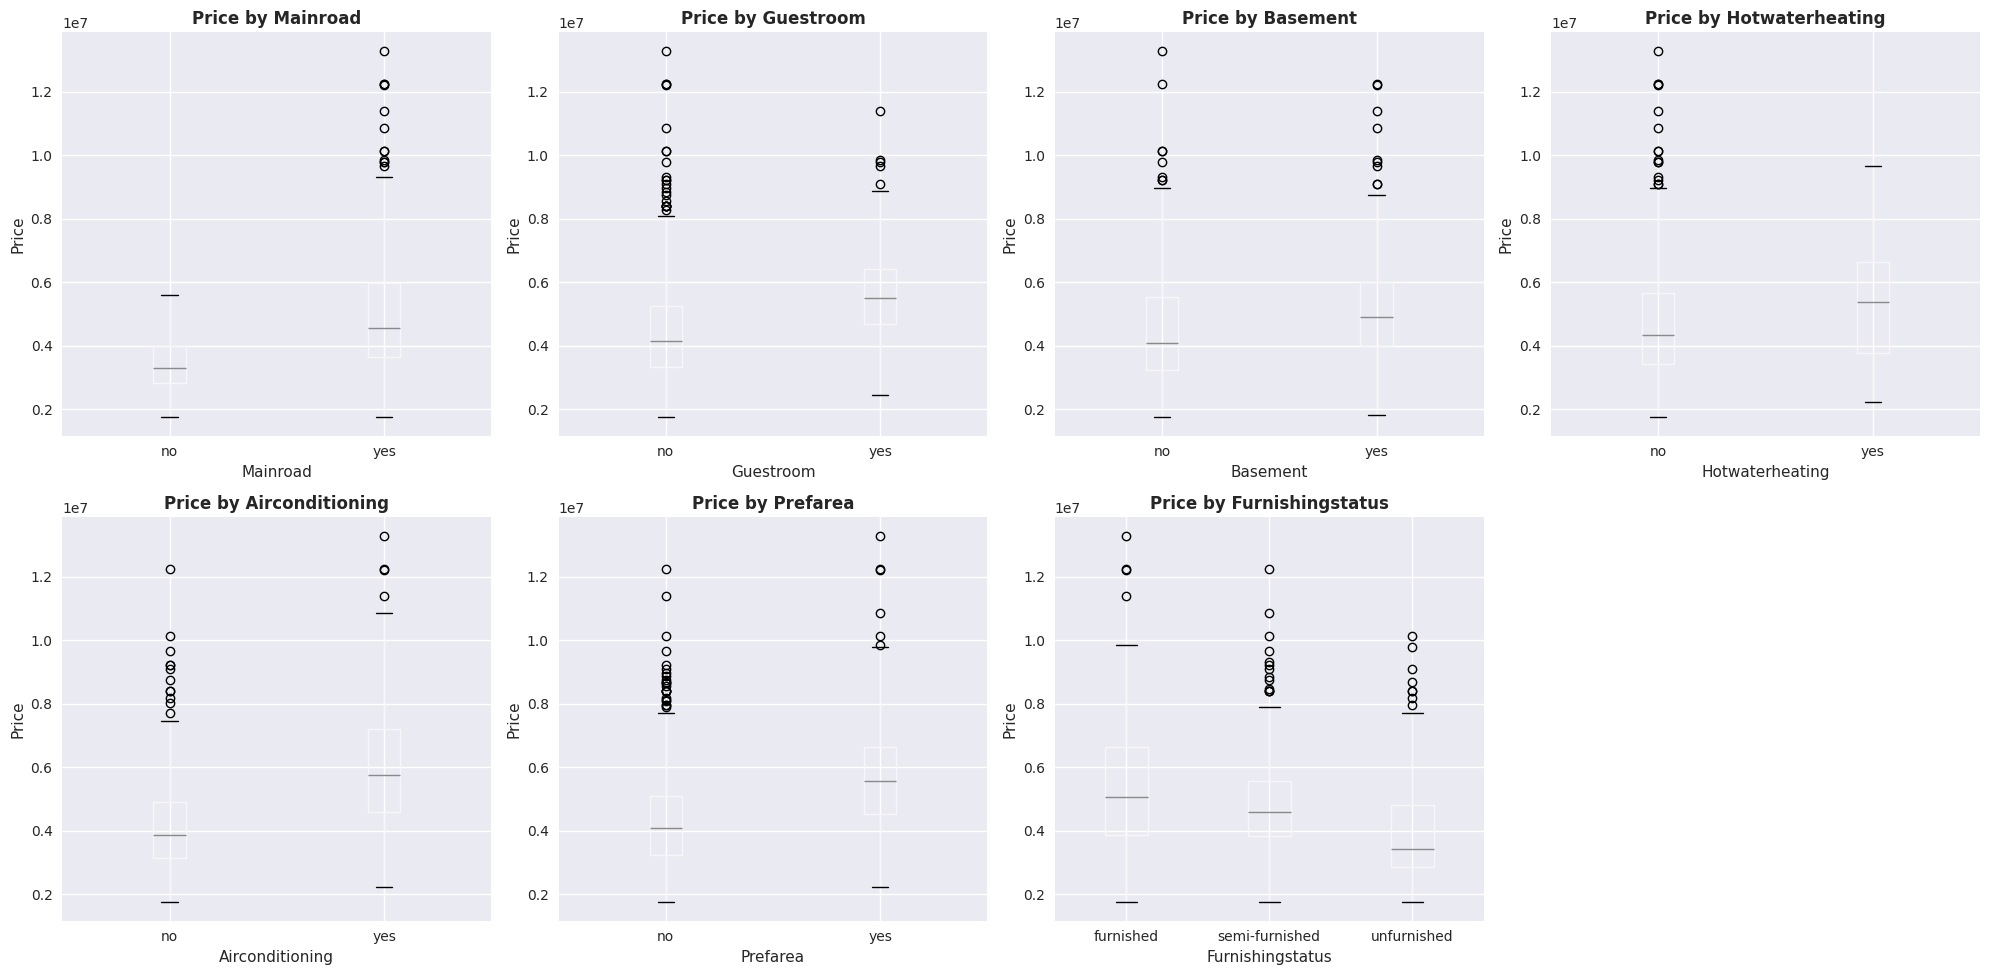

In [ ]:
# Analyze the impact of categorical features on house price
if df is not None:
    categorical_columns = df.select_dtypes(include=['object']).columns  # Identify categorical columns

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Create a 2x4 grid of subplots
    axes = axes.flatten()  # Flatten axes array for easy indexing

    # Generate box plots for each categorical feature
    for i, col in enumerate(categorical_columns):
        if i < len(axes):
            df.boxplot(column='price', by=col, ax=axes[i])  # Box plot of price grouped by category
            axes[i].set_title(f'Price by {col.title()}', fontweight='bold')
            axes[i].set_xlabel(col.title())
            axes[i].set_ylabel('Price')

    # Hide any unused subplots
    for i in range(len(categorical_columns), len(axes)):
        axes[i].set_visible(False)

    plt.suptitle('')  # Remove default subplot title
    plt.tight_layout()
    plt.show()

## 3. Data Preprocessing

In [ ]:
# Create a copy of the dataset for preprocessing
if df is not None:
    df_processed = df.copy()  # Preserve original data

    print("Original dataset shape:", df.shape)
    print("Processing dataset...")

    # Identify numerical and categorical columns
    numerical_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()

    print(f"\nNumerical columns: {numerical_cols}")
    print(f"Categorical columns: {categorical_cols}")

    # Exclude target variable 'price' from feature list
    if 'price' in numerical_cols:
        numerical_cols.remove('price')

    print(f"\nFeature columns (numerical): {numerical_cols}")
    print(f"Feature columns (categorical): {categorical_cols}")

Original dataset shape: (545, 13)
Processing dataset...

Numerical columns: ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
Categorical columns: ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

Feature columns (numerical): ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
Feature columns (categorical): ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']


In [ ]:
# Encode categorical variables using Label Encoding
if df is not None:
    label_encoders = {}  # Dictionary to store encoders for each column

    for col in categorical_cols:
        le = LabelEncoder()
        df_processed[col + '_encoded'] = le.fit_transform(df_processed[col])  # Add encoded column
        label_encoders[col] = le  # Store encoder for future use
        print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")  # Show encoding map

    # Drop original categorical columns and retain encoded versions
    encoded_cols = [col + '_encoded' for col in categorical_cols]
    df_processed = df_processed.drop(columns=categorical_cols)

    print(f"\nProcessed dataset shape: {df_processed.shape}")
    print("\nFinal feature columns:")
    feature_columns = numerical_cols + encoded_cols  # Combine numerical and encoded features
    print(feature_columns)

Encoded mainroad: {'no': np.int64(0), 'yes': np.int64(1)}
Encoded guestroom: {'no': np.int64(0), 'yes': np.int64(1)}
Encoded basement: {'no': np.int64(0), 'yes': np.int64(1)}
Encoded hotwaterheating: {'no': np.int64(0), 'yes': np.int64(1)}
Encoded airconditioning: {'no': np.int64(0), 'yes': np.int64(1)}
Encoded prefarea: {'no': np.int64(0), 'yes': np.int64(1)}
Encoded furnishingstatus: {'furnished': np.int64(0), 'semi-furnished': np.int64(1), 'unfurnished': np.int64(2)}

Processed dataset shape: (545, 13)

Final feature columns:
['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'mainroad_encoded', 'guestroom_encoded', 'basement_encoded', 'hotwaterheating_encoded', 'airconditioning_encoded', 'prefarea_encoded', 'furnishingstatus_encoded']


In [ ]:
# Detect and visualize outliers using the IQR method
if df is not None:
    def detect_outliers(df, column):
        Q1 = df[column].quantile(0.25)  # First quartile
        Q3 = df[column].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 1.5 * IQR  # Lower threshold for outliers
        upper_bound = Q3 + 1.5 * IQR  # Upper threshold for outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]  # Identify outliers
        return outliers, lower_bound, upper_bound

    print("Outlier Analysis:")
    print("=" * 50)

    # Apply outlier detection to selected numerical features
    for col in ['price', 'area'] + numerical_cols:
        if col in df_processed.columns:
            outliers, lower, upper = detect_outliers(df_processed, col)
            print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(df_processed)*100:.1f}%)")
            print(f"  Range: [{lower:.0f}, {upper:.0f}]")

    # Visualize outliers using boxplots for key features
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    key_features = ['price', 'area', 'bedrooms']

    for i, feature in enumerate(key_features):
        if feature in df_processed.columns:
            axes[i].boxplot(df_processed[feature])  # Boxplot for feature
            axes[i].set_title(f'{feature.title()} Boxplot', fontweight='bold')
            axes[i].set_ylabel(feature.title())
            axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Outlier Analysis:
price: 15 outliers (2.8%)
  Range: [-35000, 9205000]
area: 12 outliers (2.2%)
  Range: [-540, 10500]
area: 12 outliers (2.2%)
  Range: [-540, 10500]
bedrooms: 12 outliers (2.2%)
  Range: [0, 4]
bathrooms: 1 outliers (0.2%)
  Range: [-0, 4]
stories: 41 outliers (7.5%)
  Range: [-0, 4]
parking: 12 outliers (2.2%)
  Range: [-2, 2]


## 4. Feature Engineering and Scaling

In [ ]:
# Prepare feature matrix and target variable for modeling
if df is not None:
    # Define input features and target variable
    X = df_processed[feature_columns]
    y = df_processed['price']

    print(f"Feature matrix shape: {X.shape}")
    print(f"Target vector shape: {y.shape}")

    # Split data into training and testing sets (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"\nTraining set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")

    # Apply standard scaling to features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform training data
    X_test_scaled = scaler.transform(X_test)        # Transform test data using same scaler

    print("\nFeature scaling completed!")
    print(f"Feature means after scaling (should be ~0): {np.mean(X_train_scaled, axis=0)[:5]}")
    print(f"Feature std after scaling (should be ~1): {np.std(X_train_scaled, axis=0)[:5]}")

Feature matrix shape: (545, 12)
Target vector shape: (545,)

Training set: 436 samples
Testing set: 109 samples

Feature scaling completed!
Feature means after scaling (should be ~0): [ 1.22226388e-16  1.62968517e-16  7.33358328e-17  6.92616199e-17
 -6.51874070e-17]
Feature std after scaling (should be ~1): [1. 1. 1. 1. 1.]


## 5. Model Training and Evaluation

### 5.1 Linear Regression Model

In [ ]:
# Train and evaluate a Linear Regression model
if df is not None:
    print("Training Linear Regression Model...")
    print("=" * 40)

    # Initialize and fit the model on scaled training data
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train)

    # Generate predictions for training and test sets
    y_train_pred_lr = lr_model.predict(X_train_scaled)
    y_test_pred_lr = lr_model.predict(X_test_scaled)

    # Compute evaluation metrics for training and test sets
    lr_train_mae = mean_absolute_error(y_train, y_train_pred_lr)
    lr_test_mae = mean_absolute_error(y_test, y_test_pred_lr)
    lr_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
    lr_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
    lr_train_r2 = r2_score(y_train, y_train_pred_lr)
    lr_test_r2 = r2_score(y_test, y_test_pred_lr)

    # Display model performance
    print("Linear Regression Results:")
    print(f"Training MAE: ${lr_train_mae:,.2f}")
    print(f"Testing MAE: ${lr_test_mae:,.2f}")
    print(f"Training RMSE: ${lr_train_rmse:,.2f}")
    print(f"Testing RMSE: ${lr_test_rmse:,.2f}")
    print(f"Training R²: {lr_train_r2:.4f}")
    print(f"Testing R²: {lr_test_r2:.4f}")

    # Perform 5-fold cross-validation using negative MAE as scoring
    cv_scores_lr = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
    print(f"\nCross-validation MAE: ${-cv_scores_lr.mean():,.2f} (±${cv_scores_lr.std()*2:,.2f})")

Training Linear Regression Model...
Linear Regression Results:
Training MAE: $718,146.60
Testing MAE: $979,679.69
Training RMSE: $984,836.44
Testing RMSE: $1,331,071.42
Training R²: 0.6854
Testing R²: 0.6495

Cross-validation MAE: $746,881.21 (±$150,559.11)


### 5.2 Gradient Boosting Regressor Model

In [ ]:
# Train and evaluate a Gradient Boosting Regressor
if df is not None:
    print("Training Gradient Boosting Regressor...")
    print("=" * 40)

    # Initialize and fit the model with specified hyperparameters
    gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
    gb_model.fit(X_train_scaled, y_train)

    # Generate predictions for training and test sets
    y_train_pred_gb = gb_model.predict(X_train_scaled)
    y_test_pred_gb = gb_model.predict(X_test_scaled)

    # Compute evaluation metrics for training and test sets
    gb_train_mae = mean_absolute_error(y_train, y_train_pred_gb)
    gb_test_mae = mean_absolute_error(y_test, y_test_pred_gb)
    gb_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_gb))
    gb_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_gb))
    gb_train_r2 = r2_score(y_train, y_train_pred_gb)
    gb_test_r2 = r2_score(y_test, y_test_pred_gb)

    # Display model performance
    print("Gradient Boosting Results:")
    print(f"Training MAE: ${gb_train_mae:,.2f}")
    print(f"Testing MAE: ${gb_test_mae:,.2f}")
    print(f"Training RMSE: ${gb_train_rmse:,.2f}")
    print(f"Testing RMSE: ${gb_test_rmse:,.2f}")
    print(f"Training R²: {gb_train_r2:.4f}")
    print(f"Testing R²: {gb_test_r2:.4f}")

    # Perform 5-fold cross-validation using negative MAE as scoring
    cv_scores_gb = cross_val_score(gb_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
    print(f"\nCross-validation MAE: ${-cv_scores_gb.mean():,.2f} (±${cv_scores_gb.std()*2:,.2f})")

Training Gradient Boosting Regressor...
Gradient Boosting Results:
Training MAE: $148,933.77
Testing MAE: $1,045,788.32
Training RMSE: $199,436.80
Testing RMSE: $1,419,329.63
Training R²: 0.9871
Testing R²: 0.6015

Cross-validation MAE: $805,435.41 (±$226,446.33)


### 5.3 Model Comparison

In [ ]:
# Compare performance of Linear Regression and Gradient Boosting models
if df is not None:
    # Create a summary dataframe with evaluation metrics
    comparison_data = {
        'Model': ['Linear Regression', 'Gradient Boosting'],
        'Training_MAE': [lr_train_mae, gb_train_mae],
        'Testing_MAE': [lr_test_mae, gb_test_mae],
        'Training_RMSE': [lr_train_rmse, gb_train_rmse],
        'Testing_RMSE': [lr_test_rmse, gb_test_rmse],
        'Training_R2': [lr_train_r2, gb_train_r2],
        'Testing_R2': [lr_test_r2, gb_test_r2],
        'CV_MAE': [-cv_scores_lr.mean(), -cv_scores_gb.mean()]  # Convert negative scores to positive
    }

    comparison_df = pd.DataFrame(comparison_data)

    print("Model Performance Comparison:")
    print("=" * 50)
    display(comparison_df.round(2))  # Display rounded metrics for readability

    # Visualize model performance across metrics
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Create subplots for MAE, RMSE, and R²

    models = comparison_df['Model']
    x_pos = np.arange(len(models))  # X-axis positions for bars

    # MAE Comparison
    axes[0].bar(x_pos - 0.2, comparison_df['Training_MAE'], 0.4, label='Training', alpha=0.7)
    axes[0].bar(x_pos + 0.2, comparison_df['Testing_MAE'], 0.4, label='Testing', alpha=0.7)
    axes[0].set_xlabel('Models')
    axes[0].set_ylabel('Mean Absolute Error')
    axes[0].set_title('MAE Comparison', fontweight='bold')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(models)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # RMSE Comparison
    axes[1].bar(x_pos - 0.2, comparison_df['Training_RMSE'], 0.4, label='Training', alpha=0.7)
    axes[1].bar(x_pos + 0.2, comparison_df['Testing_RMSE'], 0.4, label='Testing', alpha=0.7)
    axes[1].set_xlabel('Models')
    axes[1].set_ylabel('Root Mean Square Error')
    axes[1].set_title('RMSE Comparison', fontweight='bold')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(models)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # R² Score Comparison
    axes[2].bar(x_pos - 0.2, comparison_df['Training_R2'], 0.4, label='Training', alpha=0.7)
    axes[2].bar(x_pos + 0.2, comparison_df['Testing_R2'], 0.4, label='Testing', alpha=0.7)
    axes[2].set_xlabel('Models')
    axes[2].set_ylabel('R² Score')
    axes[2].set_title('R² Score Comparison', fontweight='bold')
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(models)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Model Performance Comparison:


Model  Training_MAE  Testing_MAE  Training_RMSE  Testing_RMSE  \
0  Linear Regression     718146.60    979679.69      984836.44    1331071.42   
1  Gradient Boosting     148933.77   1045788.32      199436.80    1419329.63   

   Training_R2  Testing_R2     CV_MAE  
0         0.69        0.65  746881.21  
1         0.99        0.60  805435.41

## 6. Model Visualization and Analysis

### 6.1 Predicted vs Actual Prices

In [ ]:
# Visualize predicted vs actual house prices for both models
if df is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Create side-by-side plots

    # Linear Regression: scatter plot of actual vs predicted prices
    axes[0].scatter(y_test, y_test_pred_lr, alpha=0.6, color='blue')
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Reference line
    axes[0].set_xlabel('Actual Prices')
    axes[0].set_ylabel('Predicted Prices')
    axes[0].set_title(f'Linear Regression: Predicted vs Actual\nR² = {lr_test_r2:.4f}', fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    # Gradient Boosting: scatter plot of actual vs predicted prices
    axes[1].scatter(y_test, y_test_pred_gb, alpha=0.6, color='green')
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Reference line
    axes[1].set_xlabel('Actual Prices')
    axes[1].set_ylabel('Predicted Prices')
    axes[1].set_title(f'Gradient Boosting: Predicted vs Actual\nR² = {gb_test_r2:.4f}', fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### 6.2 Residual Analysis

In [ ]:
# Generate residual plots for both models
if df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Create 2x2 grid of plots

    # Calculate residuals for test set
    lr_residuals = y_test - y_test_pred_lr
    gb_residuals = y_test - y_test_pred_gb

    # Linear Regression: residuals vs predicted prices
    axes[0, 0].scatter(y_test_pred_lr, lr_residuals, alpha=0.6, color='blue')
    axes[0, 0].axhline(y=0, color='red', linestyle='--')  # Reference line at zero
    axes[0, 0].set_xlabel('Predicted Prices')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Linear Regression: Residuals vs Predicted', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    # Linear Regression: residual distribution histogram
    axes[0, 1].hist(lr_residuals, bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 1].set_xlabel('Residuals')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Linear Regression: Residual Distribution', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

    # Gradient Boosting: residuals vs predicted prices
    axes[1, 0].scatter(y_test_pred_gb, gb_residuals, alpha=0.6, color='green')
    axes[1, 0].axhline(y=0, color='red', linestyle='--')  # Reference line at zero
    axes[1, 0].set_xlabel('Predicted Prices')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Gradient Boosting: Residuals vs Predicted', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # Gradient Boosting: residual distribution histogram
    axes[1, 1].hist(gb_residuals, bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[1, 1].set_xlabel('Residuals')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Gradient Boosting: Residual Distribution', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print residual statistics for both models
    print("Residual Analysis:")
    print("=" * 30)
    print(f"Linear Regression:")
    print(f"  Mean residual: {lr_residuals.mean():.2f}")
    print(f"  Std residual: {lr_residuals.std():,.2f}")
    print(f"\nGradient Boosting:")
    print(f"  Mean residual: {gb_residuals.mean():.2f}")
    print(f"  Std residual: {gb_residuals.std():,.2f}")

Residual Analysis:
Linear Regression:
  Mean residual: 140585.42
  Std residual: 1,329,740.18

Gradient Boosting:
  Mean residual: 195100.71
  Std residual: 1,412,350.03


### 6.3 Feature Importance Analysis

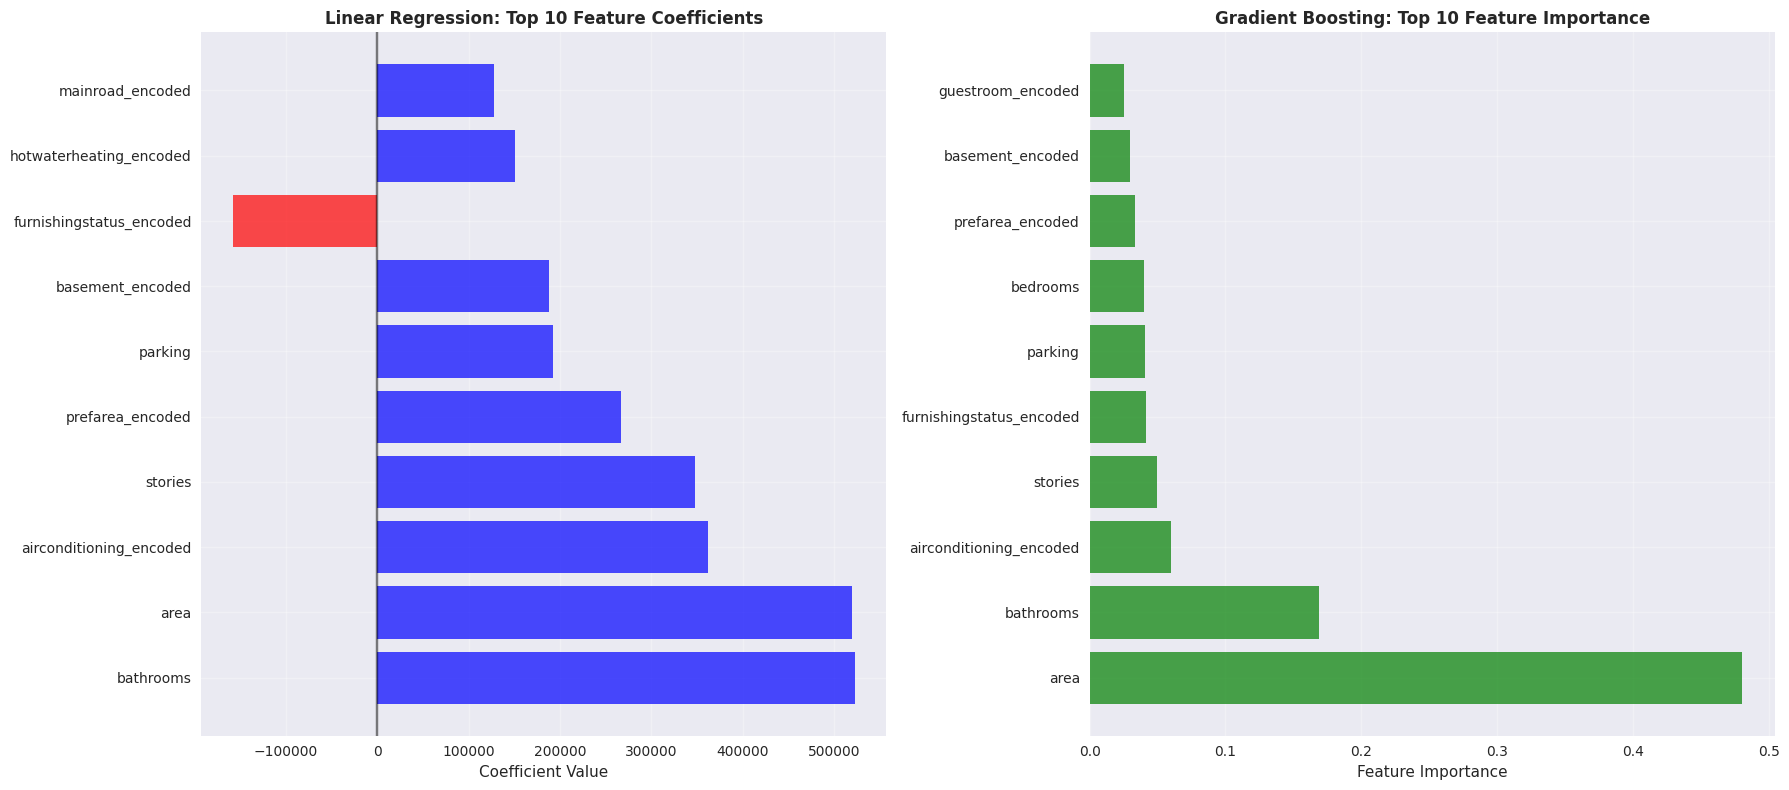

Top 5 Most Important Features:
Linear Regression (by absolute coefficient):


Feature    Coefficient  Abs_Coefficient
2                 bathrooms  523153.382843    523153.382843
0                      area  519288.130105    519288.130105
9   airconditioning_encoded  362446.186466    362446.186466
3                   stories  348177.113610    348177.113610
10         prefarea_encoded  266661.049149    266661.049149


Gradient Boosting (by importance):


Feature  Importance
0                       area    0.480447
2                  bathrooms    0.168682
9    airconditioning_encoded    0.060163
3                    stories    0.049238
11  furnishingstatus_encoded    0.041371

In [ ]:
# Analyze and visualize feature importance for both models
if df is not None:
    # Extract and sort Linear Regression coefficients by absolute value
    lr_coefficients = pd.DataFrame({
        'Feature': feature_columns,
        'Coefficient': lr_model.coef_,
        'Abs_Coefficient': np.abs(lr_model.coef_)
    }).sort_values('Abs_Coefficient', ascending=False)

    # Extract and sort Gradient Boosting feature importances
    gb_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': gb_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # Create side-by-side plots

    # Plot top 10 Linear Regression coefficients
    top_lr_features = lr_coefficients.head(10)
    colors_lr = ['red' if x < 0 else 'blue' for x in top_lr_features['Coefficient']]  # Color by sign
    axes[0].barh(range(len(top_lr_features)), top_lr_features['Coefficient'], color=colors_lr, alpha=0.7)
    axes[0].set_yticks(range(len(top_lr_features)))
    axes[0].set_yticklabels(top_lr_features['Feature'])
    axes[0].set_xlabel('Coefficient Value')
    axes[0].set_title('Linear Regression: Top 10 Feature Coefficients', fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].axvline(x=0, color='black', linestyle='-', alpha=0.5)  # Reference line at zero

    # Plot top 10 Gradient Boosting feature importances
    top_gb_features = gb_importance.head(10)
    axes[1].barh(range(len(top_gb_features)), top_gb_features['Importance'], color='green', alpha=0.7)
    axes[1].set_yticks(range(len(top_gb_features)))
    axes[1].set_yticklabels(top_gb_features['Feature'])
    axes[1].set_xlabel('Feature Importance')
    axes[1].set_title('Gradient Boosting: Top 10 Feature Importance', fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Display top 5 features for each model
    print("Top 5 Most Important Features:")
    print("=" * 35)
    print("Linear Regression (by absolute coefficient):")
    display(lr_coefficients.head())
    print("\nGradient Boosting (by importance):")
    display(gb_importance.head())

## 7. Model Performance Summary and Recommendations

In [ ]:
# Display final summary and recommendations based on model analysis
if df is not None:
    print("=" * 80)
    print("HOUSE PRICE PREDICTION MODEL ANALYSIS - FINAL SUMMARY")
    print("=" * 80)

    # Dataset overview
    print("\n1. DATASET OVERVIEW:")
    print(f"   • Total samples: {len(df):,}")
    print(f"   • Features: {len(feature_columns)}")
    print(f"   • Price range: ${df['price'].min():,.0f} - ${df['price'].max():,.0f}")
    print(f"   • Average price: ${df['price'].mean():,.0f}")

    # Model performance metrics
    print("\n2. MODEL PERFORMANCE COMPARISON:")
    print(f"   Linear Regression:")
    print(f"     • Test MAE: ${lr_test_mae:,.0f}")
    print(f"     • Test RMSE: ${lr_test_rmse:,.0f}")
    print(f"     • Test R²: {lr_test_r2:.4f}")
    print(f"     • Cross-val MAE: ${-cv_scores_lr.mean():,.0f}")

    print(f"\n   Gradient Boosting:")
    print(f"     • Test MAE: ${gb_test_mae:,.0f}")
    print(f"     • Test RMSE: ${gb_test_rmse:,.0f}")
    print(f"     • Test R²: {gb_test_r2:.4f}")
    print(f"     • Cross-val MAE: ${-cv_scores_gb.mean():,.0f}")

    # Determine best performing model based on test MAE
    if gb_test_mae < lr_test_mae:
        best_model = "Gradient Boosting"
        improvement = ((lr_test_mae - gb_test_mae) / lr_test_mae) * 100
    else:
        best_model = "Linear Regression"
        improvement = ((gb_test_mae - lr_test_mae) / gb_test_mae) * 100

    print(f"\n3. BEST PERFORMING MODEL: {best_model}")
    print(f"   • Performance improvement: {improvement:.1f}% lower MAE")

    # Key insights from feature importance and model performance
    print("\n4. KEY INSIGHTS:")
    print(f"   • Most important features (Gradient Boosting): {', '.join(gb_importance.head(3)['Feature'].tolist())}")
    print(f"   • Average prediction error: ${min(lr_test_mae, gb_test_mae):,.0f}")
    print(f"   • Model explains ~{max(lr_test_r2, gb_test_r2)*100:.1f}% of price variance")

    # Final recommendations based on model behavior and business context
    print("\n5. RECOMMENDATIONS:")
    if gb_test_r2 > lr_test_r2:
        print("   • Use Gradient Boosting model for production deployment")
        print("   • The model captures non-linear relationships better")
    else:
        print("   • Linear Regression provides good interpretability")
        print("   • Consider ensemble methods for improved performance")

    print("   • Focus on area, bedrooms, and location features for pricing")
    print("   • Consider collecting more data for outlier properties")
    print("   • Regular model retraining recommended as market conditions change")

    print("\n" + "=" * 80)

HOUSE PRICE PREDICTION MODEL ANALYSIS - FINAL SUMMARY

1. DATASET OVERVIEW:
   • Total samples: 545
   • Features: 12
   • Price range: $1,750,000 - $13,300,000
   • Average price: $4,766,729

2. MODEL PERFORMANCE COMPARISON:
   Linear Regression:
     • Test MAE: $979,680
     • Test RMSE: $1,331,071
     • Test R²: 0.6495
     • Cross-val MAE: $746,881

   Gradient Boosting:
     • Test MAE: $1,045,788
     • Test RMSE: $1,419,330
     • Test R²: 0.6015
     • Cross-val MAE: $805,435

3. BEST PERFORMING MODEL: Linear Regression
   • Performance improvement: 6.3% lower MAE

4. KEY INSIGHTS:
   • Most important features (Gradient Boosting): area, bathrooms, airconditioning_encoded
   • Average prediction error: $979,680
   • Model explains ~64.9% of price variance

5. RECOMMENDATIONS:
   • Linear Regression provides good interpretability
   • Consider ensemble methods for improved performance
   • Focus on area, bedrooms, and location features for pricing
   • Consider collecting more 

## 8. Sample Predictions

In [ ]:
# Generate and display sample predictions from both models
if df is not None:
    print("Sample Predictions on Test Data:")
    print("=" * 50)

    # Select first 10 samples from the test set
    sample_indices = range(min(10, len(y_test)))

    # Create a dataframe with actual and predicted prices, and absolute errors
    results_df = pd.DataFrame({
        'Actual_Price': y_test.iloc[sample_indices].values,
        'LR_Predicted': y_test_pred_lr[sample_indices],
        'GB_Predicted': y_test_pred_gb[sample_indices],
        'LR_Error': np.abs(y_test.iloc[sample_indices].values - y_test_pred_lr[sample_indices]),
        'GB_Error': np.abs(y_test.iloc[sample_indices].values - y_test_pred_gb[sample_indices])
    })

    # Format numeric columns as currency for readability
    for col in ['Actual_Price', 'LR_Predicted', 'GB_Predicted', 'LR_Error', 'GB_Error']:
        results_df[col] = results_df[col].apply(lambda x: f"${x:,.0f}")

    display(results_df)  # Display formatted prediction results

    # Final remarks on model extensibility
    print("\nNote: This analysis demonstrates the complete workflow for house price prediction.")
    print("The models can be further improved with hyperparameter tuning, feature engineering,")
    print("and ensemble methods based on specific business requirements.")

Sample Predictions on Test Data:


Actual_Price LR_Predicted GB_Predicted    LR_Error    GB_Error
0   $4,060,000   $5,203,692   $4,797,021  $1,143,692    $737,021
1   $6,650,000   $7,257,004   $7,369,835    $607,004    $719,835
2   $3,710,000   $3,062,829   $3,593,927    $647,171    $116,073
3   $6,440,000   $4,559,592   $4,594,943  $1,880,408  $1,845,057
4   $2,800,000   $3,332,932   $4,005,165    $532,932  $1,205,165
5   $4,900,000   $3,563,081   $3,110,058  $1,336,919  $1,789,942
6   $5,250,000   $5,645,466   $5,522,514    $395,466    $272,514
7   $4,543,000   $6,413,980   $5,368,722  $1,870,980    $825,722
8   $2,450,000   $2,755,832   $2,768,975    $305,832    $318,975
9   $3,353,000   $2,668,939   $3,013,147    $684,061    $339,853


Note: This analysis demonstrates the complete workflow for house price prediction.
The models can be further improved with hyperparameter tuning, feature engineering,
and ensemble methods based on specific business requirements.
